# **EFC 2 - Classification**

You have a dataset consisting of 3168 labeled samples. Each sample is described by 19 acoustic attributes extracted from recorded voice snippets, considering the frequency range of 0 to 280 Hz. The last column corresponds to the label associated with each pattern, being '1' for male gender and '0' for female gender.

**a)** Perform an analysis of the characteristics of the input attributes, considering the respective histograms and correlation measures between them.

**b)** Construct the logistic regression model to classify the patterns.


##**Loading libraries**

In [48]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import math
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#read files from drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##**Item A**

###**Loading dataset**

https://www.mldata.io/dataset-details/gender_voice/

In [5]:
#-------------------------------------------------------------------#
#                    Load clean dataframe                           #
#-------------------------------------------------------------------#
getfile = drive.CreateFile({'id':'1Akt7j2cg4CVgdwV9iDyq85kEqjf7oaeJ'}) #classroom
getfile.GetContentFile('dados_voz_genero.csv')
voz = pd.read_csv('dados_voz_genero.csv')

#variable types
print(voz.dtypes)
print('\n\nsamples = ',len(voz))
voz.head()

sd          float64
median      float64
Q25         float64
Q75         float64
IQR         float64
skew        float64
kurt        float64
sp.ent      float64
sfm         float64
mode        float64
centroid    float64
meanfun     float64
minfun      float64
maxfun      float64
meandom     float64
mindom      float64
maxdom      float64
dfrange     float64
modindx     float64
label       float64
dtype: object


samples =  3168


,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1.0
1,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1.0
2,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1.0
3,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1.0
4,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1.0


###**Variables names**

19 variables x 3168 samples

| Name 	| Type 	| Description 	|
|-	|:-:	|-	|
| sd 	| float 	| standard deviation of frequency 	|
| median 	| float 	| median frequency (in kHz) 	|
| Q25 	| float 	| first quantile (in kHz) 	|
| Q75 	| float 	| third quantile (in kHz) 	|
| IQR 	| float 	| interquantile range (in kHz) 	|
| skew 	| float 	| skewness (see note in specprop description) 	|
| kurt 	| float 	| kurtosis (see note in specprop description) 	|
| sp.ent 	| float 	| spectral entropy 	|
| sfm 	| float 	| spectral flatness 	|
| mode 	| float 	| mode frequency 	|
| centroid 	| float 	| frequency centroid (see specprop) 	|
| meanfun 	| float 	| average of fundamental frequency measured across acoustic signal 	|
| minfun 	| float 	| minimum fundamental frequency measured across acoustic signal 	|
| maxfun 	| float 	| maximum fundamental frequency measured across acoustic signal 	|
| meandom 	| float 	| average of dominant frequency measured across acoustic signal 	|
| mindom 	| float 	| minimum of dominant frequency measured across acoustic signal 	|
| maxdom 	| float 	| maximum of dominant frequency measured across acoustic signal 	|
| dfrange 	| float 	| range of dominant frequency measured across acoustic signal 	|
| modindx 	| float 	| modulation index. Calculated as the accumulated absolute difference between <br>adjacent measurements of fundamental frequencies divided by the frequency range 	|
| label 	| string 	| Predictor class, male or female 	|

In [ ]:
#creating sex column
sex = np.array(['woman','man'])
codes = np.array(voz['label'].astype(int))
voz['sex'] = pd.Categorical.from_codes(codes, sex)

The dataframe is balanced

In [11]:
#target variable balance
print('label frequencies: ')
print(voz['sex'].value_counts())
print('\nNumber of variables: ',len(voz.columns))

label frequencies: 
woman    1584
man      1584
Name: sex, dtype: int64

Number of variables:  21


###**A) Correlations and histograms**

#### **Distributions - Histogram and Density**

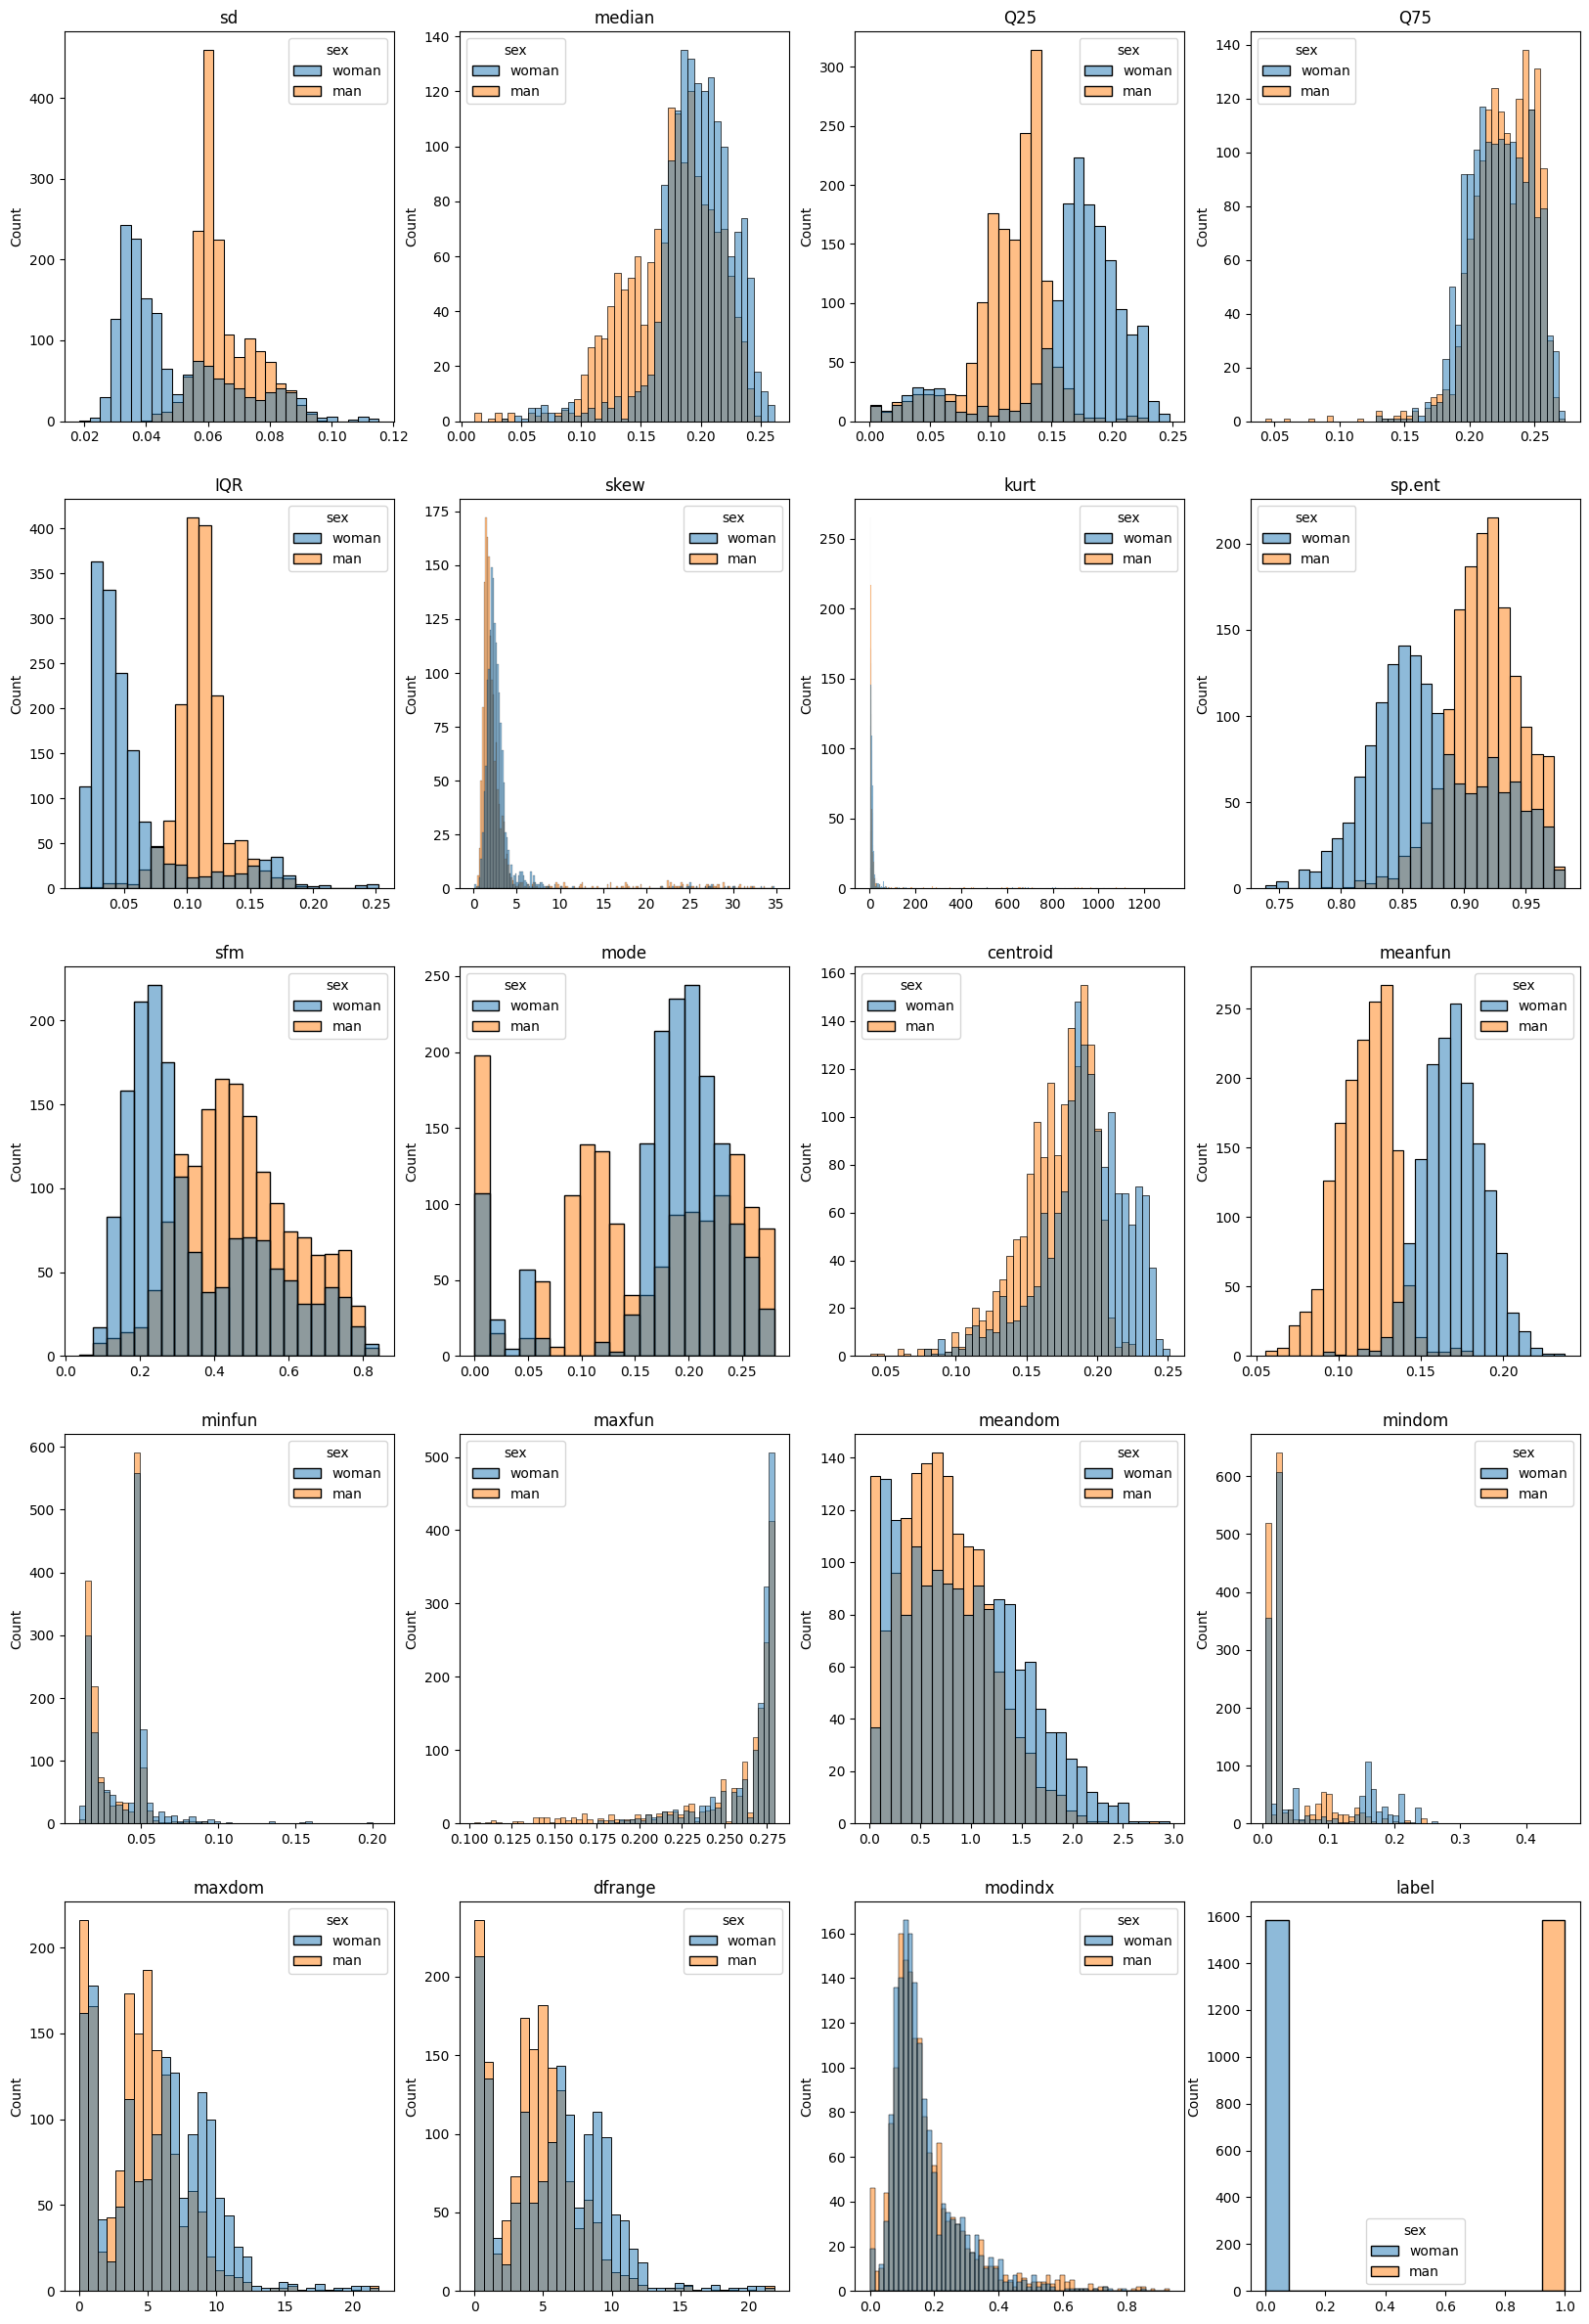

In [12]:
#Histogram
f, axs = plt.subplots(5, 4,figsize=(20,30))
for i,col in enumerate(voz.columns[:20]):
    plt.subplot(5, 4, i+1)
    sns.histplot(voz,x=col,hue='sex')
    plt.title(col)
    plt.xlabel('')

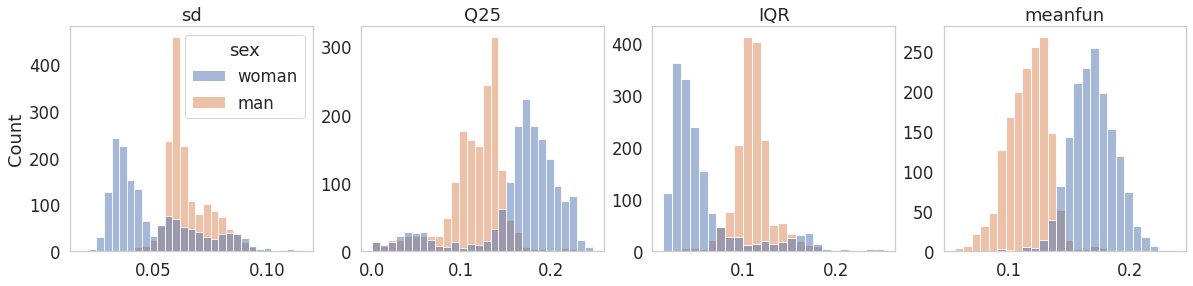

In [ ]:
#Histograms for divergent distributions
f, axs = plt.subplots(1, 4,figsize=(20,24))
for i,col in enumerate(voz[['sd','Q25','IQR','meanfun']]):
    plt.subplot(5, 4, i+1)
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})
    if i == 0:
        sns.histplot(voz,x=col,hue='sex')
        plt.title(col)
        plt.xlabel('')
        plt.ylabel('Count')
    else:
        sns.histplot(voz,x=col,hue='sex',legend=False)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.title(col)
        plt.ylabel('')
        plt.xlabel('')

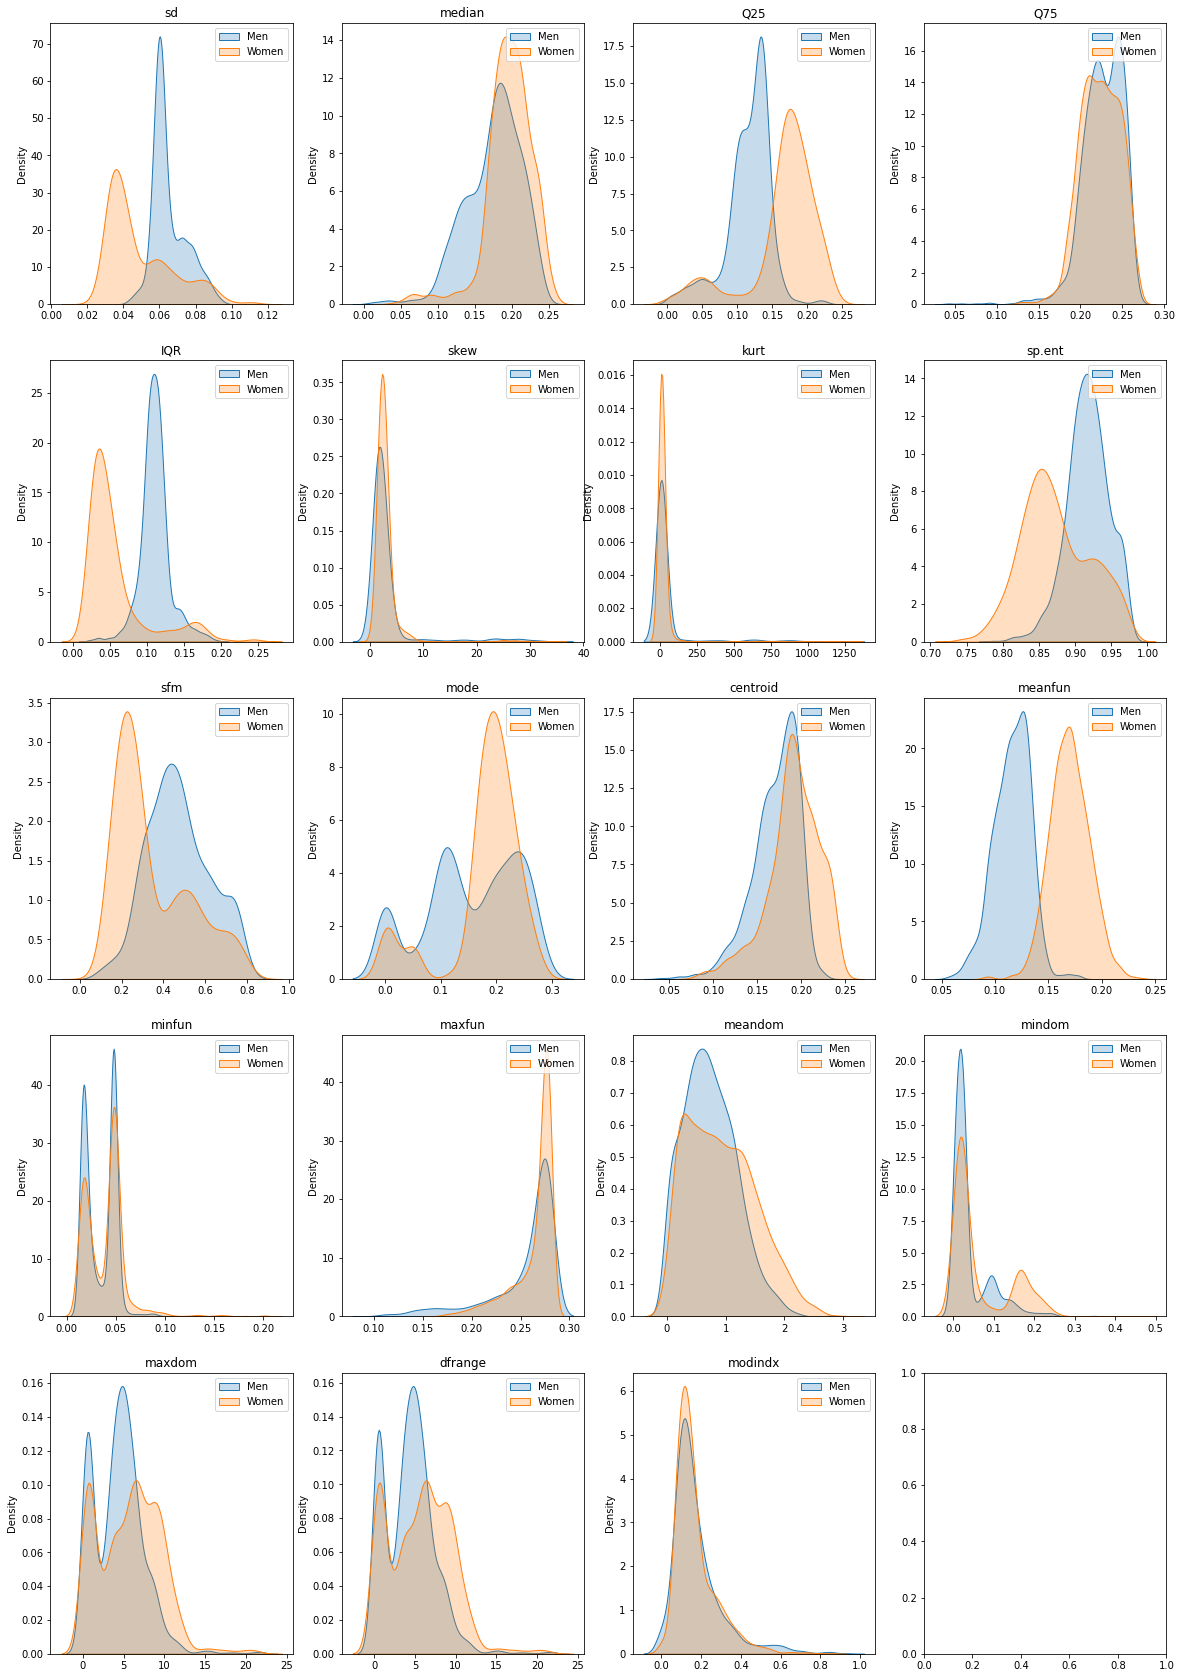

In [ ]:
#Density
f, axs = plt.subplots(5, 4,figsize=(20,30))
for i, col in enumerate(voz.columns[:19]):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(voz.loc[voz['label'] == 1, col], label='Men',shade=True)
    sns.kdeplot(voz.loc[voz['label'] == 0, col], label='Women',shade=True)
    plt.xlabel('cm')
    plt.title(col)
    plt.xlabel('')
    plt.legend()

####**Correlation Heat Map**

We also analyzed the Pearson correlations between variables to identify attributes that are more correlated with each other, as multicollinearity can introduce bias to our classifier. Since the dataset contains numerous variables, we chose to assess the correlations through a heatmap, which allows for a quick and visual identification. From this figure, we identified some variables with high direct correlations: `maxdom` and `dfrange` (1), `skew` and `kurt` (0.98), `centroid` and `median` (0.93), and `centroid` and `Q25` (0.91). Additionally, we observed variables with high inverse correlations: `Q25` and `IQR` (-0.87) and `Q25` and `sd` (-0.85).


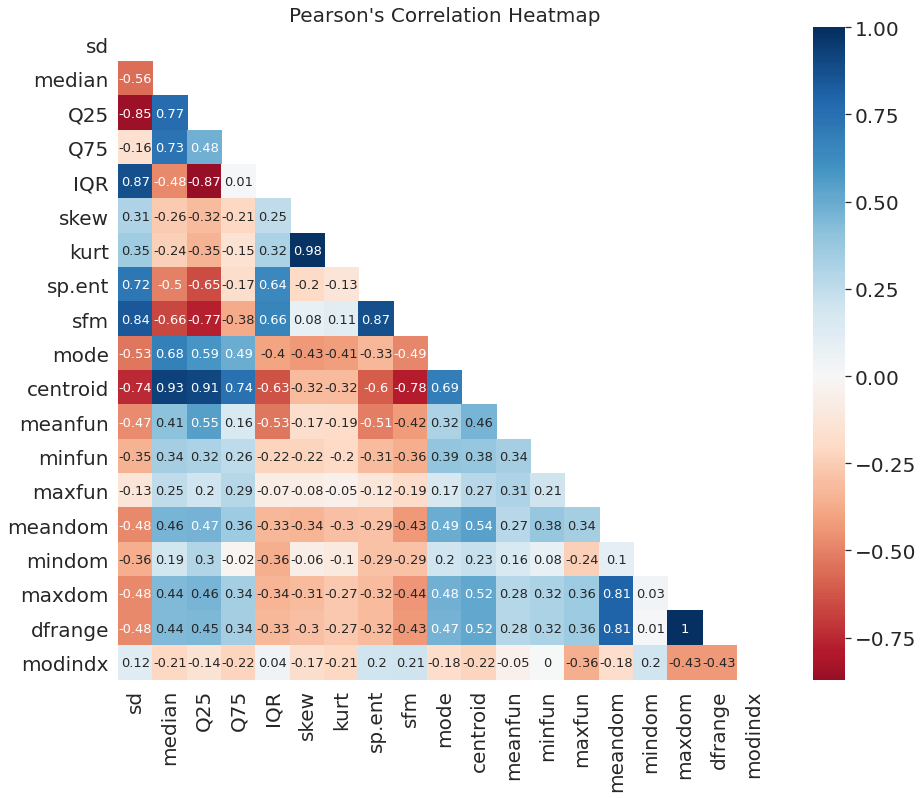

In [ ]:
cor = voz.drop(labels = ['label'],axis=1)
pear = round(cor.corr(),2)
teste = np.array(pear)
mask = np.zeros_like(pear)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(pear, mask=mask, vmax=1, square=True,center=0,annot=True,annot_kws={"fontsize":13}, cmap="RdBu")
    plt.title('''Pearson's Correlation Heatmap''',fontsize = 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    cax = plt.gcf().axes[-1] #para alterar fonte do eixo y direito
    cax.tick_params(labelsize=20) #para alterar fonte do eixo y direito

###**B) Logistic regression for classification**

In the preprocessing stage, we randomly split 80% of the data for training and 20% for validation, following the ​*hold-out*​ technique, using the `train_test_split` function from ​`sklearn.model_selection`​. Due to the significant scale difference between variables, the attributes were linearly normalized, ensuring their values ranged between 0 and 1.


####**Split train and test**

In [14]:
X = voz.iloc[:,0:19]
Y = voz['label']

print(X.head())
print(Y.head())

         sd    median       Q25       Q75       IQR       skew         kurt  \
0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   274.402906   
1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   634.613855   
2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155  1024.927705   
3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831     4.177296   
4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174     4.333713   

     sp.ent       sfm      mode  centroid   meanfun    minfun    maxfun  \
0  0.893369  0.491918  0.000000  0.059781  0.084279  0.015702  0.275862   
1  0.892193  0.513724  0.000000  0.066009  0.107937  0.015826  0.250000   
2  0.846389  0.478905  0.000000  0.077316  0.098706  0.015656  0.271186   
3  0.963322  0.727232  0.083878  0.151228  0.088965  0.017798  0.250000   
4  0.971955  0.783568  0.104261  0.135120  0.106398  0.016931  0.266667   

    meandom    mindom    maxdom   dfrange   modindx  
0  0.007812  0.00781

In [42]:
#use train_test_slip from sklearn to slip data
#  20% of data for test
#  use random_state as a int for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

In [38]:
#confirm if slip was done correctly
#X
print(f'X_train:{round(len(X_train)/len(X)*100,2)}%')
print(f'X_test:{round(len(X_test)/len(X)*100,2)}%')
#Y
print(f'Y_train:{round(len(Y_train)/len(Y)*100,2)}%')
print(f'Y_test:{round(len(Y_test)/len(Y)*100,2)}%')

X_train:79.99%
X_test:20.01%
Y_train:79.99%
Y_test:20.01%


####**Normalize data**

In [43]:
for c in X_train.columns:
  min = X_train[f'{c}'].min() #define min and max from train dataset
  max = X_train[f'{c}'].max()
  X_train[f'{c}'] = (X_train[f'{c}']-min)/(max-min)

for c in X.columns:
  min = X_test[f'{c}'].min() #define min and max from train dataset
  max = X_test[f'{c}'].max()
  X_test[f'{c}'] = (X_test[f'{c}']-min)/(max-min)

In [ ]:
X.describe()

,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


####**Fit Model**

In [18]:
X.columns

Index(['sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm',
       'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom',
       'maxdom', 'dfrange', 'modindx'],
      dtype='object')

In [45]:
#Drop correlated variables (if you want to)
X_train = X_train.drop(labels=['skew','maxdom'],axis=1)
X_train

X_test = X_test.drop(labels=['skew','maxdom'],axis=1)
X_test

,sd,median,Q25,Q75,IQR,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,dfrange,modindx
1166,0.394805,0.604704,0.602694,0.859168,0.392331,0.001808,0.788967,0.533915,0.556164,0.625838,0.555075,0.221319,0.990719,0.600199,0.410989,0.403433,0.111038
1391,0.367003,0.876677,0.611262,0.917325,0.418447,0.001851,0.593299,0.197266,0.982047,0.764019,0.381256,0.220192,0.871206,0.312062,0.041758,0.225322,0.124146
408,0.368759,0.780101,0.574882,0.832425,0.404182,0.006280,0.732845,0.437719,0.871645,0.685116,0.318542,0.092382,0.353286,0.257012,0.358242,0.310086,0.161661
1483,0.416503,0.363098,0.444454,0.584617,0.386779,0.014182,0.738123,0.560555,0.386364,0.426406,0.289882,0.074644,0.954643,0.195889,0.006593,0.206009,0.193789
3088,0.334379,0.567445,0.683255,0.424430,0.052575,0.066543,0.556694,0.492688,0.591646,0.485874,0.552987,0.047860,0.593016,0.057554,0.153846,0.012518,0.109021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,0.107828,0.763234,0.753665,0.740722,0.170804,0.003065,0.463783,0.181248,0.839921,0.739274,0.589417,0.246913,0.954643,0.244673,0.041758,0.174893,0.079849
1127,0.437875,0.563701,0.589480,0.830167,0.388245,0.003693,0.787925,0.609431,0.993113,0.610650,0.421771,0.219631,0.963508,0.660934,0.041758,0.412017,0.144017
2795,0.184822,0.624998,0.694584,0.625589,0.161203,0.009078,0.551357,0.285550,0.600000,0.652736,0.595473,0.217688,1.000000,0.555109,0.621978,0.417382,0.115318
211,0.639663,0.631437,0.432584,0.717284,0.477753,0.011708,0.866146,0.763175,0.055165,0.441950,0.352594,0.241302,0.981544,0.440280,0.006593,0.203147,0.228297


#### **Default fit**

In [46]:
model = LogisticRegression()
model.fit(X_train, Y_train)

#Accuracy
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)
print(f"Acuracy of the model:{round(accuracy*100,2)}%")

Acuracy of the model:97.32%


####**Tunning hyperparameters**
- C
- Penalty

In [50]:
model = LogisticRegression()
folds = KFold(5,random_state = 5,shuffle=True)

# define grid
grid = dict()
grid['C'] = np.logspace(-4, 4, 20)
grid['penalty'] = ['l1', 'l2']
grid['solver'] = ['liblinear']

# define search
search = GridSearchCV(model, grid, scoring='neg_log_loss', cv=folds)

# perform the search
results = search.fit(X_train, Y_train)
C = results.best_params_['C']
penalty = results.best_params_['penalty']
print('best score: ',results.best_score_)
print('best C: ',C)
print('best penalty: ',penalty)

#Fit tunned model
model = LogisticRegression(C=C, penalty=penalty,solver='liblinear')
model.fit(X_train, Y_train)
#Accuracy
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)
print(f"Acuracy of the tunned model:{round(accuracy*100,2)}%")

best score:  -0.09340057320238916
best C:  78.47599703514607
best penalty:  l2
Acuracy of the tunned model:97.32%


####**Log loss calculation**
- sklearn
- manually

#### Equation:

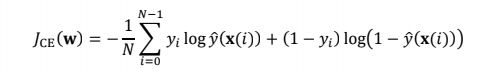

In [52]:
#Log-loss
print('log-loss sklearn:    ',metrics.log_loss(Y_test,model.predict_proba(X_test)[:,1]))

log-loss sklearn:     0.09862793800173592


####**Best threshold**

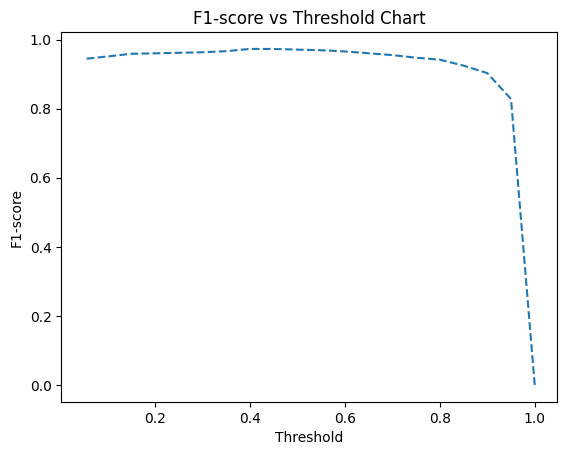

In [53]:
#alternative to AO MODEL.PREDICT
pred_proba_df = pd.DataFrame(model.predict_proba(X_test)) #probabilities for all classes by the label of class.
threshold_list = list(np.arange(1,0,-0.05))

f1 = []
fxt = pd.DataFrame()

for i in threshold_list:
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0) #choose 1 or 0 based on limiar probability
    f1score = metrics.f1_score(Y_test, Y_test_pred.iloc[:,1])
    f1.append(f1score)

fxt['f1'] = f1
fxt['t'] = threshold_list

plt.title("F1-score vs Threshold Chart")
plt.plot(fxt['t'],fxt['f1'] , "--")
plt.ylabel("F1-score")
plt.xlabel("Threshold")
plt.show()

With this, we concluded that 0.4 is the most suitable value for the *threshold*, as it maximizes the F1 score. Therefore, we adopted this value and increased the accuracy of our model from 97.32% to 97.48%.


####**Tunning treshold**

In [54]:
limiar = fxt['t'][fxt['f1'].idxmax()]
print('best threshold: ',limiar)
pred_proba_df['classificação'] = np.where(pred_proba_df.iloc[:,1]>limiar,1,0)
accuracy = accuracy_score(Y_test,pred_proba_df['classificação'])
print(f"Acuracy of the model:{round(accuracy*100,2)}%")

best threshold:  0.39999999999999947
Acuracy of the model:97.48%


####**ROC curve**

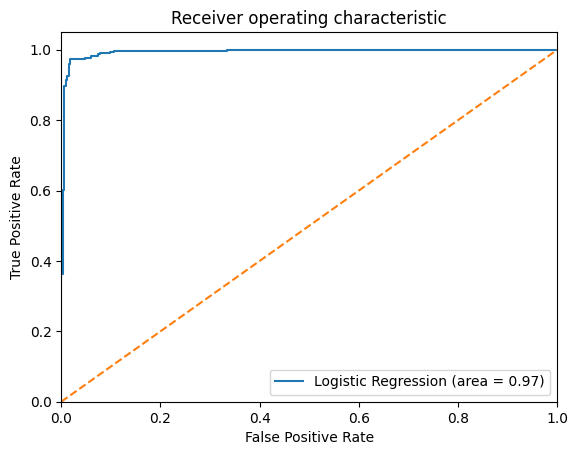

In [68]:
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

With this model with optimized parameters, we obtained the Receiver Operating Characteristic (ROC) curve, where each point on the curve represents a classifier with a different *threshold*. The resulting ROC curve illustrates the good performance of the model, achieving a high True Positive Rate (TPR) and a low False Positive Rate (FPR).


####**F-measure**

In [64]:
print(classification_report(Y_test,pred_proba_df['classificação']))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       336
         1.0       0.97      0.97      0.97       298

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



####**Confusion matrix**

In [69]:
cm = confusion_matrix(Y_test, pred_proba_df['classificação'])
print(confusion_matrix(Y_test, pred_proba_df['classificação']))

[[328   8]
 [  8 290]]


In [70]:
df_cm = pd.DataFrame(cm)

In [71]:
cm_norm = cm / cm.astype(np.float).sum(axis=1)
df_cm_norm = pd.DataFrame(cm_norm)

<ipython-input-71-489436d2d57b>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_norm = cm / cm.astype(np.float).sum(axis=1)


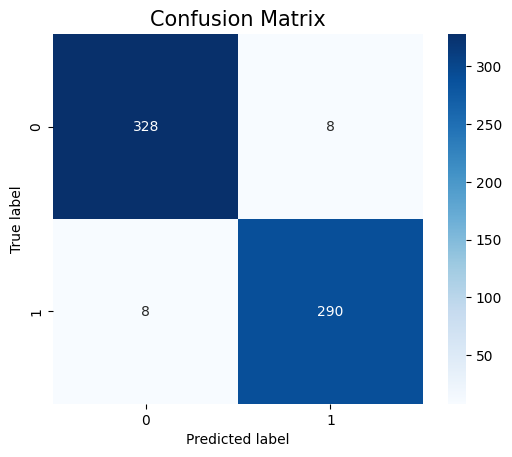

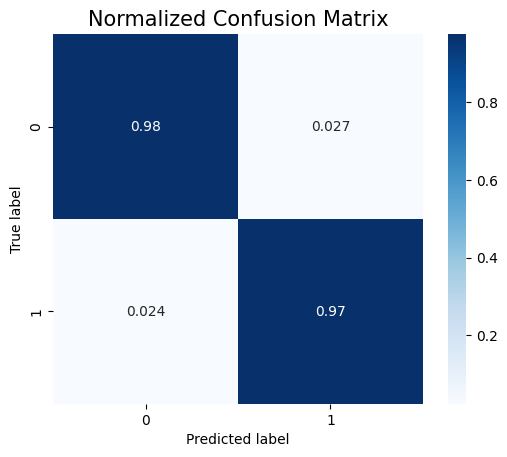

In [72]:
plt.plot(figsize=(8,8))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Confusion Matrix",fontsize = 15)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

plt.plot(figsize=(8,8))
sns.heatmap(df_cm_norm, square=True, annot=True,cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Upon observing the confusion matrix (Figure 5B), we can conclude that the precision for label '0' (female voices) is 0.98, and for label '1' (male voices) is 0.97.
